In [1]:
from pprint import pprint
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
#setup Mongo
client = MongoClient()
db = client.Yelp

#Current city can be changed to values like Matthews
city = 'Tempe'

In [2]:
# Function to fetch businesses present in given city
def getBusinessByCity(city):
    return list(db.business.find({"city": city}))

In [3]:
#Fetch list of reviews given to all businesses in the list
def getReviewsByBusId(busids):
    reviews = list(db.review.find({"business_id":{"$in":busids}}))
    return reviews

In [4]:
# Function to fetch tips for all business in the list
def getTipsByBusId(busids):
    tips = list(db.tip.find({"business_id":{"$in":busids}}))
    return tips

In [5]:
#Function to get User Infomration using user ID
def getUsersById(userids):
    users = list(db.user.find({"user_id":{"$in":userids}}))
    return users

In [6]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [7]:
def generateTFIDFMatrix(reviews):
    for b_id, text in reviews.items():
        reviews[b_id] = " ".join(text)    
    corpus = []
    count =0
    b_index_Ids={}
    for id, txt in sorted(reviews.items(), key=lambda t: str(t[0])):
        corpus.append(txt)
        b_index_Ids[count] = id
        count+=1
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0.01,max_df = 0.95, stop_words = 'english')
    tfidf_business_matrix =  tf.fit_transform(corpus)
    return (b_index_Ids,tfidf_business_matrix)
    

In [8]:
# Current city kept 
business=getBusinessByCity(city)

In [9]:
#Get list of business ids  for businesses in given City
busids = [x['business_id'] for x in business]

business_dict = dict((k, v) for (k, v) in zip(busids, business))

reviews = getReviewsByBusId(busids)

tips = getTipsByBusId(busids)

# get users to bus ids map
users_res_reviewd = {}
for r in reviews:
    if r['user_id'] in users_res_reviewd:
        users_res_reviewd[r['user_id']].append(r['business_id'])
    else:
        users_res_reviewd[r['user_id']]=[r['business_id']]

#users who have reviewed restaurants and tips
usersR = [x['user_id'] for x in reviews]
usersT = [x['user_id'] for x in tips]

#get distinct user ids
userIds = list(set(usersR))

#Fetch user information
users = getUsersById(userIds)

users_dict = dict((k, v) for (k, v) in zip(userIds, users))


In [10]:
# Print statistics
pprint(str(len(business))+ ' business.length')
pprint(str(len(reviews))+ ' reviews.length')
pprint(str(len(tips))+ ' tips.length')
pprint(str(len(users))+ ' users.length')

'3949 business.length'
'148074 reviews.length'
'32995 tips.length'
'70225 users.length'


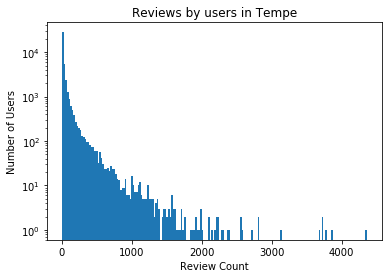

mean 54.0695741479 max 4356 min 6


In [11]:
# Print Reviews by users for current city's businesses 
# Limits 
li = sorted([int(x['review_count']) for x in users if (int(x['review_count'])>5 and int(x['review_count'])<5001 )])
plt.hist(li,bins=190)
plt.xlabel('Review Count')
plt.ylabel('Number of Users')
plt.yscale('log', nonposy='clip')
plt.title("Reviews by users in Tempe")
plt.show()
meanli = np.mean(li)
maxli=np.max(li)
minli=np.min(li)
print('mean '+str(meanli) + ' max '+str(maxli) + ' min '+str(minli))


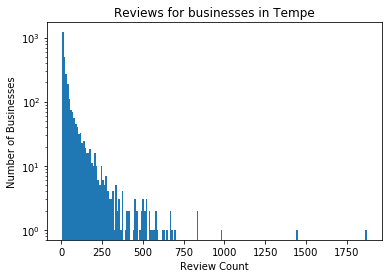

mean 49.5651874785 max 1871 min 6


In [12]:
#Get business which satisy review count constraints 
lis = sorted([int(x['review_count']) for x in business if (int(x['review_count'])>5 and int(x['review_count'])<5001 )])
plt.hist(lis,bins=190)
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')
plt.yscale('log', nonposy='clip')
plt.title("Reviews for businesses in Tempe")
plt.show()

meanlis = np.mean(lis)
maxlis=np.max(lis)
minlis=np.min(lis)
print('mean '+str(meanlis) + ' max '+str(maxlis) + ' min '+str(minlis))

In [13]:
#Business with very few reviews will be removed and reviews greater than a limit are removed. 
# Business with many reviews might have a lot of words and end up being similar to all

ignoreBusi = ([x['business_id'] for x in business if (int(x['review_count'])<=5 or int(x['review_count'])>=5001 )])

busReviews = {}
usrReviews={}
#Append all text per user and per business so we can create corpus for them
for rev in reviews:
    if rev['business_id'] not in ignoreBusi:
        if rev['business_id'] in busReviews:
            busReviews[rev['business_id']].append(rev['text'])
        else:
            busReviews[rev['business_id']] = [rev['text']]
        if rev['user_id'] in usrReviews:
            usrReviews[rev['user_id']].append(rev['text'])
        else:
            usrReviews[rev['user_id']] = [rev['text']]

In [14]:
#Generate TF IDF matrix for business
bus_index_Ids,tfidf_business_matrix = generateTFIDFMatrix(busReviews)

# Use svd approach to reduce dimensionality of TF IDF matrix
svd = TruncatedSVD(n_components=100)
svdBusinessMatrix = svd.fit_transform(tfidf_business_matrix)

In [15]:
#Generate cosine similarity matrix here we are finding similar businesses
simBusMatrix = cosine_similarity(svdBusinessMatrix)
suggest_res_dict = {}
for i in range(len(simBusMatrix)):
    suggest_res = np.argsort(simBusMatrix[i])[::-1][1:15]
    suggest_res_ids = [bus_index_Ids[i] for i  in suggest_res ][:]
    suggest_res_dict[bus_index_Ids[i]] = suggest_res_ids


In [16]:
#Generate TF IDF matrix for users
userIds,tfidf_user_matrix = generateTFIDFMatrix(usrReviews)
# Use svd approach to reduce dimensionality of TF IDF matrix
svd1 = TruncatedSVD(n_components=100)
svdUsersMatrix = svd1.fit_transform(tfidf_user_matrix)


In [17]:
# Finding similar users is 
#simUserMatrix = cosine_similarity(svdUsersMatrix)  
#suggest_users_dict = {}
#for i in range(len(simUserMatrix)):
   # suggest_user = np.argsort(simUserMatrix[i])[::-1][1:15]
    #suggest_user_ids = [userIds[i] for i  in suggest_user ][:]
    #suggest_users_dict[userIds[i]] = suggest_user_ids


In [18]:
# Here we will find business distance from users
restaurant_user_matrix = cosine_similarity(svdUsersMatrix,svdBusinessMatrix)
suggest_user_res_dict = {}
for i in range(len(restaurant_user_matrix)):
    #remove restaurants already visited.
    cosine_list = restaurant_user_matrix[i][:]
    for idx, val in enumerate(cosine_list):
        if bus_index_Ids[idx] in users_res_reviewd[userIds[i]]:
            np.delete(cosine_list , idx)
    suggest_res = np.argsort(cosine_list)[::-1][0:10]
    suggest_res_ids = [bus_index_Ids[k] for k  in suggest_res if bus_index_Ids[k] ][:]
    suggest_user_res_dict[userIds[i]] = suggest_res_ids

In [19]:
#businesspredict_id = sys.argv[1]
#This is a trial number to see results of business predicted similar to any user.
businesspredict_id = 25
    
for busi in suggest_user_res_dict[userIds[businesspredict_id]]:
    
    print(str(business_dict[busi]['name']) + ' ' + str(business_dict[busi]['categories']) + '\n')



Arizona School of Massage Therapy Tempe Campus ['Education', 'Massage Schools', 'Beauty & Spas', 'Specialty Schools', 'Massage']

KFC ['Restaurants', 'Fast Food', 'Chicken Wings']

Elements Massage ['Massage', 'Health & Medical', 'Massage Therapy', 'Beauty & Spas']

Popeyes Louisiana Kitchen ['Chicken Wings', 'American (Traditional)', 'Fast Food', 'Cajun/Creole', 'Restaurants']

Church's Chicken ['Chicken Wings', 'Restaurants']

The Added Touch Massage ['Day Spas', 'Massage Therapy', 'Health & Medical', 'Beauty & Spas']

Popeyes Louisiana Kitchen ['Restaurants', 'Fast Food', 'Chicken Wings']

Denny's ['Breakfast & Brunch', 'Diners', 'American (Traditional)', 'Restaurants']

Sami's Gyros ['Salad', 'Sandwiches', 'Restaurants', 'Mediterranean']

Massage Envy - Tempe Marketplace ['Massage', 'Skin Care', 'Beauty & Spas', 'Day Spas']



In [20]:
#Check if categories are overallping for Primary and the one's predicted as similar to it
print('Primary : ' + str(business_dict[bus_index_Ids[businesspredict_id]]['name'])  + ' ' + str(business_dict[bus_index_Ids[businesspredict_id]]['categories']) +'\n')
print('\n')
for busi in suggest_res_dict[bus_index_Ids[businesspredict_id]]:
    print(str(business_dict[busi]['name'])  + ' ' + str(business_dict[busi]['categories']) +'\n')


Primary : Cobblestone Veterinary Care ['Veterinarians', 'Pets', 'Health & Medical', 'Acupuncture']



South Point Animal Clinic ['Pets', 'Veterinarians']

Pecan Grove Veterinary Hospital ['Pets', 'Veterinarians']

Topaz Veterinary Clinic ['Veterinarians', 'Pets']

Banfield Pet Hospital ['Pets', 'Veterinarians']

Countryside Animal Hospital ['Pets', 'Veterinarians', 'Pet Groomers', 'Pet Services', 'Pet Boarding/Pet Sitting']

Tempe Veterinary Hospital ['Pets', 'Veterinarians', 'Pet Boarding/Pet Sitting', 'Pet Groomers', 'Pet Services']

Baseline Animal Clinic ['Pet Services', 'Pet Cremation Services', 'Pet Groomers', 'Pet Boarding/Pet Sitting', 'Veterinarians', 'Pets']

University Animal Hospital & Pet Resort ['Veterinarians', 'Pets', 'Pet Boarding/Pet Sitting', 'Pet Groomers', 'Pet Services']

McClintock Animal Care Center ['Veterinarians', 'Pets']

Gentle Care Animal Hospital ['Pets', 'Veterinarians']

VCA Elliot Park Animal Hospital ['Pets', 'Veterinarians']

Banfield Pet Hospital ['

In [21]:
# Calculate ratings difference between restaurant and it's similar restaurants
busi_stars_rmse=[]
for m in range(len(bus_index_Ids)):
    suggestion_list_stars = []
    for k in suggest_res_dict[bus_index_Ids[m]]:
        suggestion_list_stars.append(float(business_dict[k]['stars']))
    val = business_dict[bus_index_Ids[m]]['stars']
    curr_stars = [val] * len(suggest_res_dict[bus_index_Ids[m]])
    busi_stars_rmse.append(rmse(np.array(curr_stars),np.array(suggestion_list_stars)))


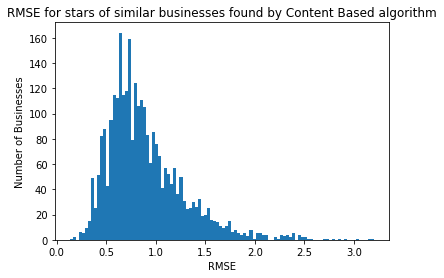

0.89419821965
0.392374349157
0.801783725737


In [22]:
# Plot graph for RMSE
plt.hist(busi_stars_rmse,bins=100)
plt.xlabel('RMSE')
plt.ylabel('Number of Businesses')
plt.title('RMSE for stars of similar businesses found by Content Based algorithm')
plt.show()
print(np.mean(busi_stars_rmse))
print(np.std(busi_stars_rmse))
print(np.median(busi_stars_rmse))

In [23]:
#user_stars_rmse=[]
#for m in range(len(bus_index_Ids)):
    #suggestion_list_stars = []
    #for k in suggest_res_dict[bus_index_Ids[m]]:
        #suggestion_list_stars.append(float(business_dict[k]['stars']))
    #val = business_dict[bus_index_Ids[m]]['stars']
    #curr_stars = [val] * len(suggest_res_dict[bus_index_Ids[m]])
    #busi_stars_rmse.append(rmse(np.array(curr_stars),np.array(suggestion_list_stars)))

1.03090156369


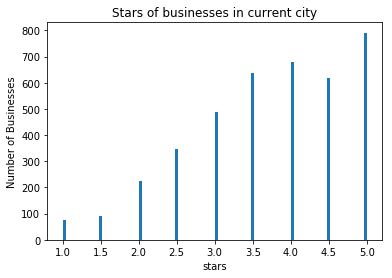

In [24]:
#This is graph of all ratings for businesses in the given city.
print(np.std([x['stars'] for x in business]))
stars = [x['stars'] for x in business]
plt.hist(stars,bins=100)
plt.xlabel('stars')
plt.ylabel('Number of Businesses')
plt.title('Stars of businesses in current city')
plt.show()